# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [7]:
df.head()

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,273,281,299,349,367,423,444,484,521,555
1,NaN,Albania,0,0,0,0,0,0,0,0,...,277,304,333,361,377,383,400,409,416,433
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,986,1171,1251,1320,1423,1468,1572,1666,1761,1825
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,428,439,466,501,525,545,564,583,601,601
4,NaN,Angola,0,0,0,0,0,0,0,0,...,8,8,10,14,16,17,19,19,19,19


In [8]:
countries = df["Country/Region"].unique()

In [9]:
countries.sort()

In [10]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [11]:
province = df["Province/State"]

In [12]:
province.dropna(inplace=True)

In [13]:
province = province.unique()

In [14]:
province.sort()

In [15]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [16]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)

        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [17]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        df.plot(logy=logy, **kwargs)
    plt.show()
            

# Switzerland

In [18]:
swiss = extract_data(df, "Switzerland")

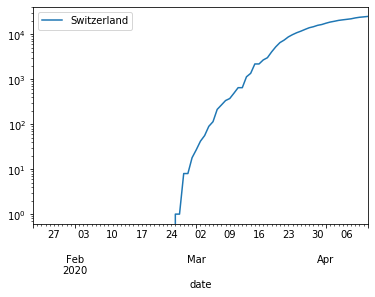

In [19]:
plot_data(swiss, logy=True)

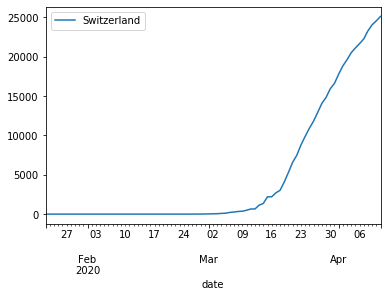

In [20]:
plot_data(swiss)

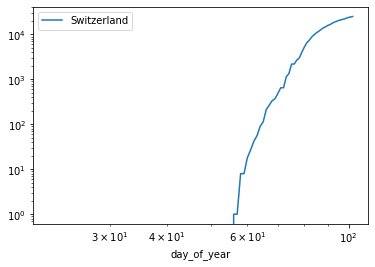

In [21]:
plot_data(swiss, logx=True, logy=True)

# Europe

In [22]:
italy = extract_data(df, "Italy")

In [23]:
france = extract_data(df, "France")

In [24]:
uk = extract_data(df, "United Kingdom")

In [25]:
spain = extract_data(df, "Spain")

In [26]:
germany =  extract_data(df, "Germany")

In [27]:
austria =  extract_data(df, "Austria")

In [28]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [29]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [30]:
europe

,,Switzerland,Italy,France,Germany,Austria,Spain,United Kingdom
date,day_of_year,,,,,,,
2020-01-22,22,0,0,0,0,0,0,0
2020-01-23,23,0,0,0,0,0,0,0
2020-01-24,24,0,0,2,0,0,0,0
2020-01-25,25,0,0,3,0,0,0,0
2020-01-26,26,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-04-07,98,22253,135586,109069,107663,12639,141942,55242
2020-04-08,99,23280,139422,112950,113296,12942,148220,60733
2020-04-09,100,24051,143626,117749,118181,13244,153222,65077


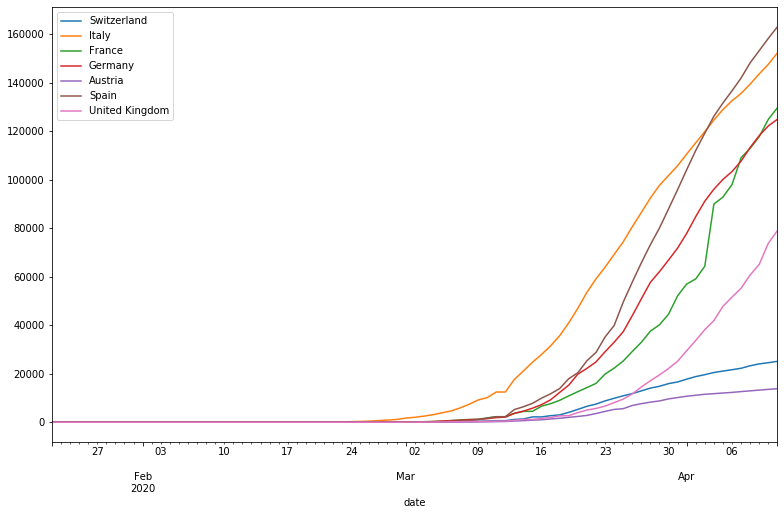

In [31]:
plot_data(europe, figsize=(13, 8))

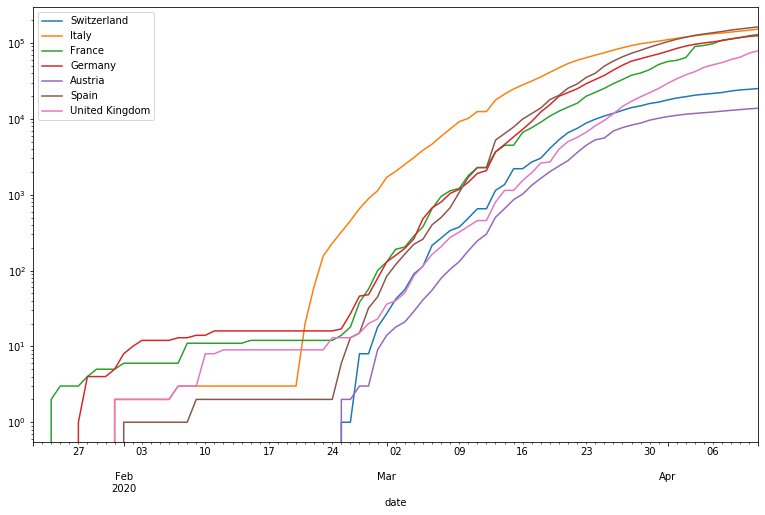

In [32]:
plot_data(europe, logy=True, figsize=(13, 8))

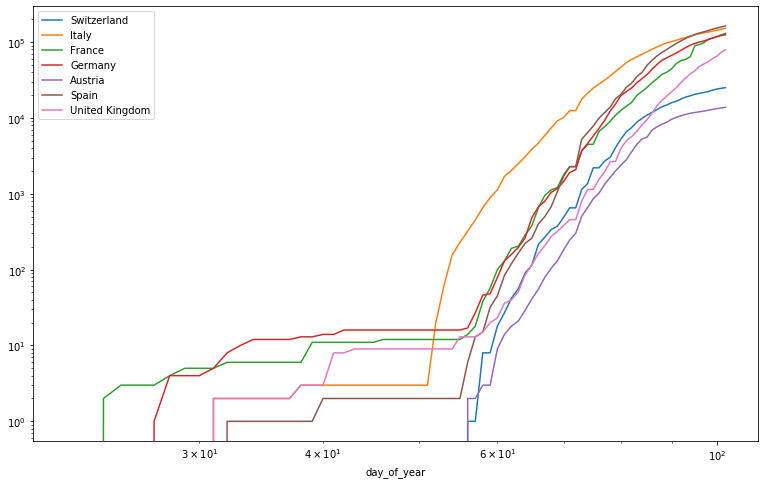

In [33]:
plot_data(europe, logx=True, logy=True, figsize=(13, 8))

# USA

In [34]:
us = extract_data(df, country="US", groupby=True)

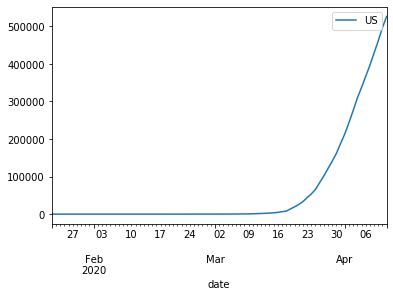

In [35]:
plot_data(us)

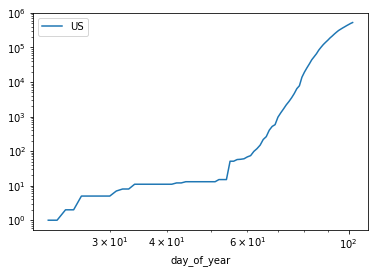

In [36]:
plot_data(us, logy=True, logx=True)

# Europe + USA

In [37]:
comp_us = pd.concat([europe, us], axis=1)

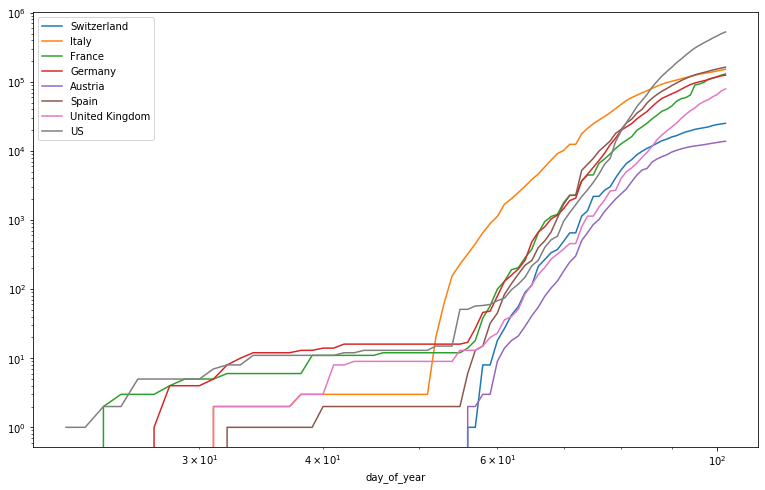

In [38]:
plot_data(comp_us, logy=True, logx=True, figsize=(13, 8))

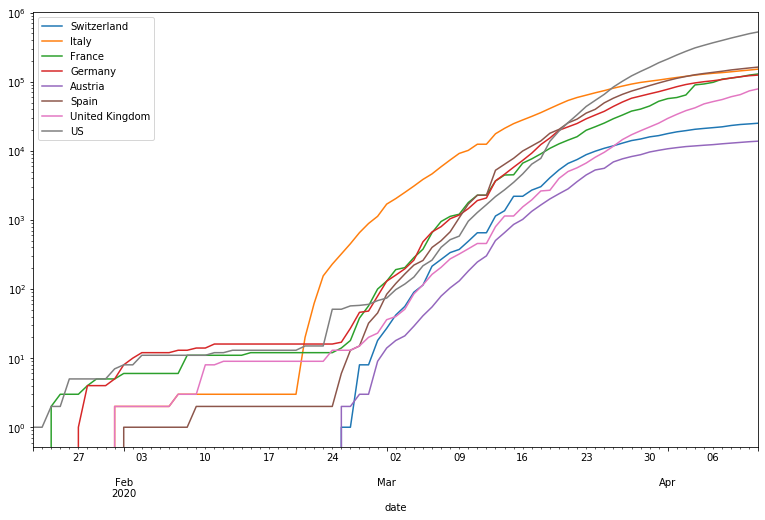

In [39]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [40]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [41]:
world.index = pd.to_datetime(world.index)

In [42]:
world["day_of_year"] = world.index.dayofyear

In [43]:
world.reset_index(inplace=True)

In [44]:
world.columns = ["date", "world_cases", "day_of_year"]

In [45]:
world.set_index(["date", "day_of_year"], inplace=True)

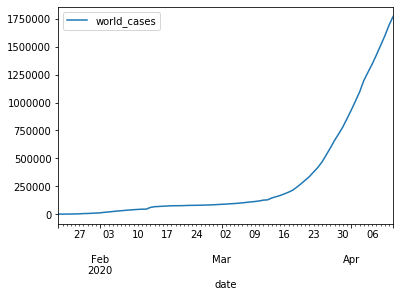

In [46]:
plot_data(world)

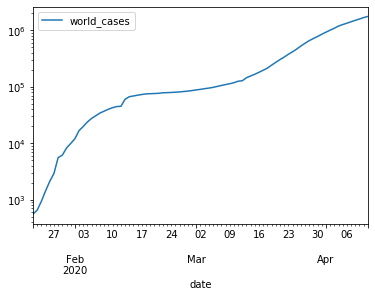

In [47]:
plot_data(world, logy=True)

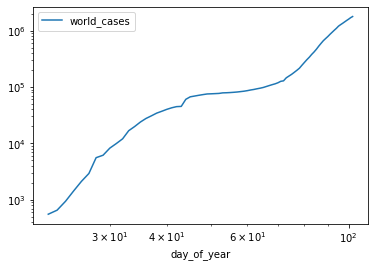

In [48]:
plot_data(world, logx=True, logy=True)

# Iran

In [49]:
iran = extract_data(df, "Iran")

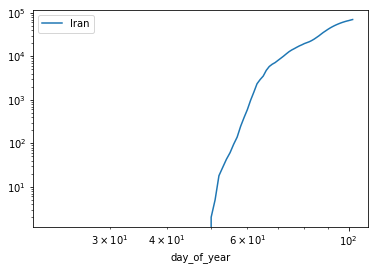

In [50]:
plot_data(iran, logy=True, logx=True)

In [51]:
comp_iran = pd.concat([comp_us, iran], axis=1)

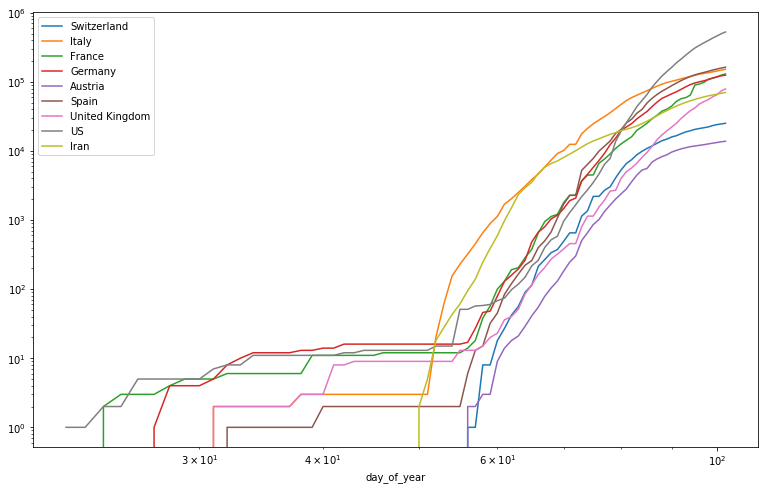

In [52]:
plot_data(comp_iran, logy=True, logx=True, figsize=(13, 8))

# China

In [53]:
china = extract_data(df, "China", groupby=True)

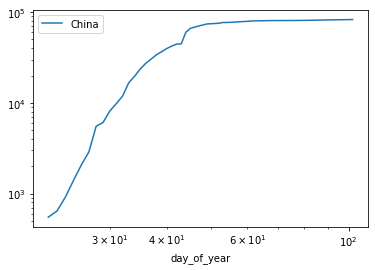

In [54]:
plot_data(china, logy=True, logx=True)

In [55]:
comp_china = pd.concat([china, comp_us], axis=1)

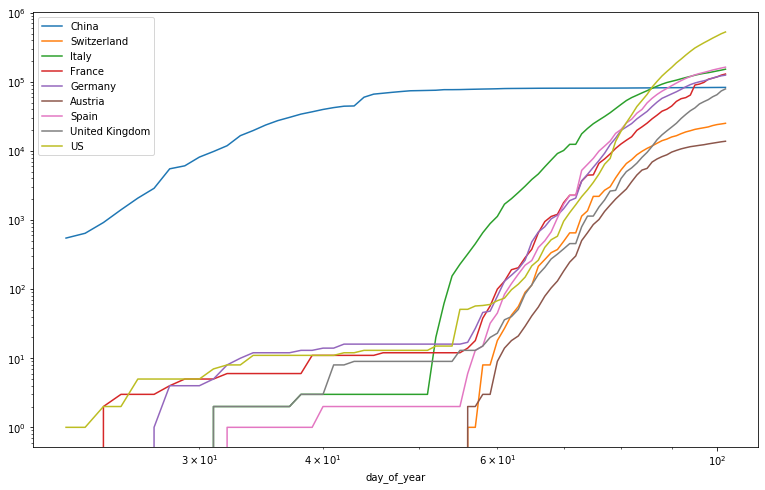

In [56]:
plot_data(comp_china, logx=True, logy=True, figsize=(13, 8))

# Shanghai

In [57]:
shanghai = extract_data(df, "China", "Shanghai")

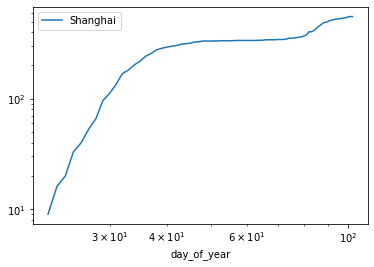

In [58]:
plot_data(shanghai, logy=True, logx=True)

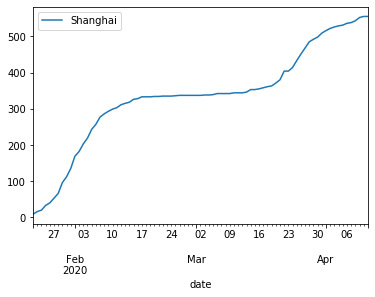

In [59]:
plot_data(shanghai)

# Singapore

In [60]:
singapore = extract_data(df, "Singapore")

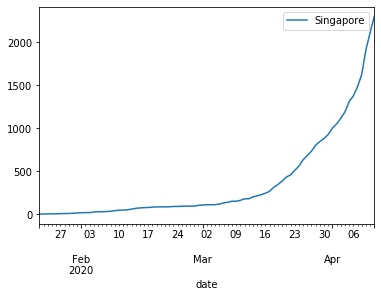

In [61]:
plot_data(singapore)

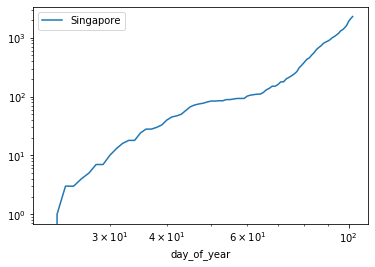

In [62]:
plot_data(singapore, logy=True, logx=True)

# South Korea

In [63]:
kr = extract_data(df, "Korea, South")

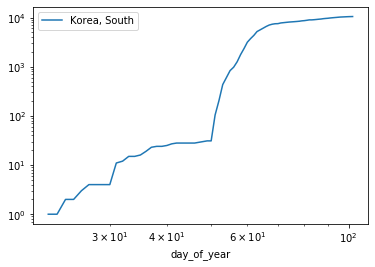

In [64]:
plot_data(kr, logy=True, logx=True)

# South Central China

## Hong Kong

In [65]:
hong_kong = extract_data(df,"China", "Hong Kong")

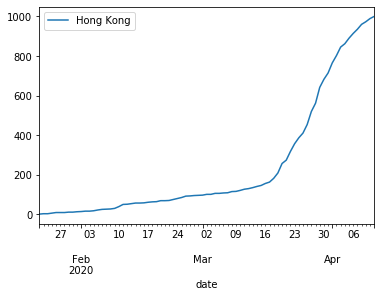

In [66]:
plot_data(hong_kong)

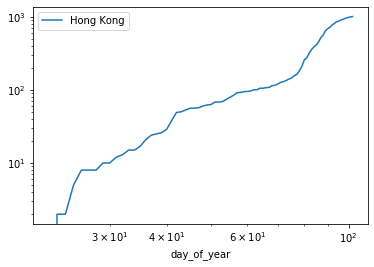

In [67]:
plot_data(hong_kong,logy=True, logx=True)

## Hubei (Wuhan)

In [68]:
hubei = extract_data(df,"China", "Hubei")

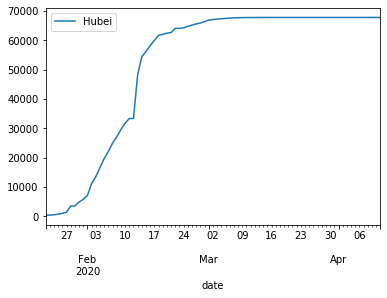

In [69]:
plot_data(hubei)

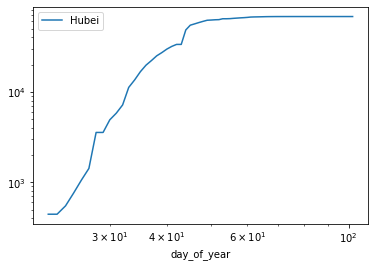

In [70]:
plot_data(hubei, logy=True, logx=True)

## Henan

In [71]:
henan = extract_data(df, "China", "Henan")

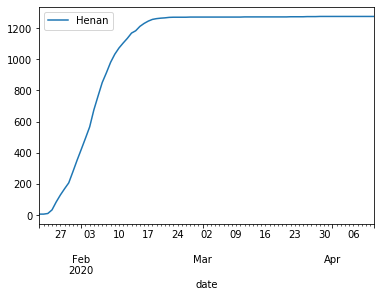

In [72]:
plot_data(henan)

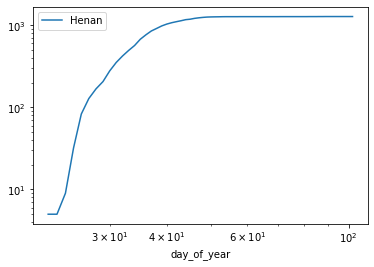

In [73]:
plot_data(henan, logy=True, logx=True)

## Hunan

In [74]:
hunan = extract_data(df, "China", "Hunan")

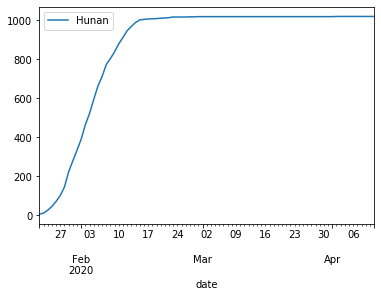

In [75]:
plot_data(hunan)

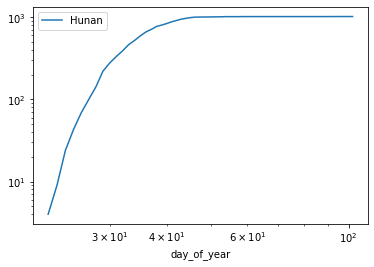

In [76]:
plot_data(hunan, logy=True, logx=True)

## Guangdong

In [77]:
guangdong = extract_data(df, "China", "Guangdong")

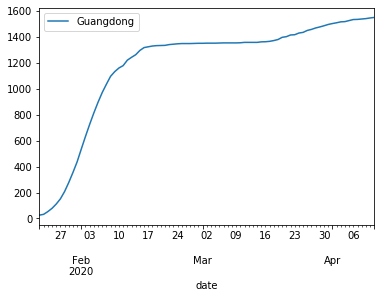

In [78]:
plot_data(guangdong)

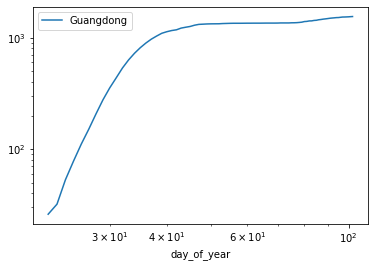

In [79]:
plot_data(guangdong, logy=True, logx=True)

## Guangxi

In [80]:
guangxi = extract_data(df, "China", "Guangxi")

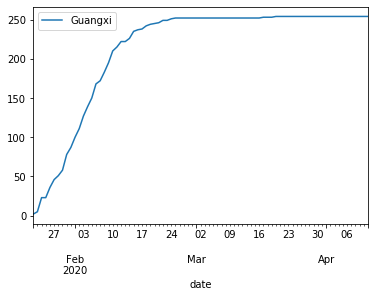

In [81]:
plot_data(guangxi)

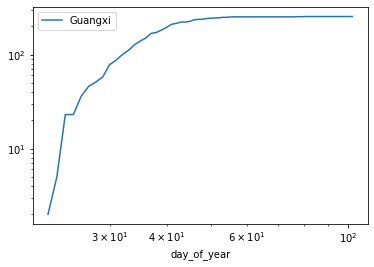

In [82]:
plot_data(guangxi, logy=True, logx=True)

# South-Asia

In [83]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

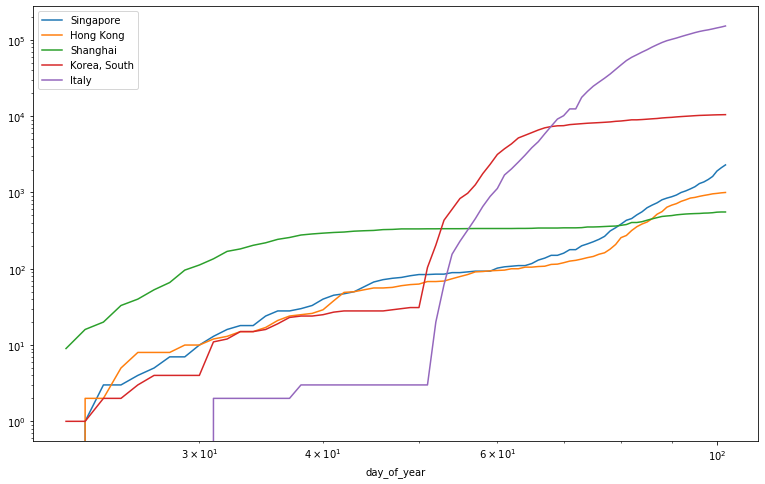

In [84]:
plot_data(south_asia, logy=True, logx=True, figsize=(13, 8))

# North Europe

In [85]:
sweden = extract_data(df, "Sweden")

In [86]:
norway = extract_data(df, "Norway")

In [87]:
danemark = extract_data(df, 'Danemark')

In [88]:
finland = extract_data(df, 'Finland')

In [89]:
nl = extract_data(df, "Netherlands")

In [90]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

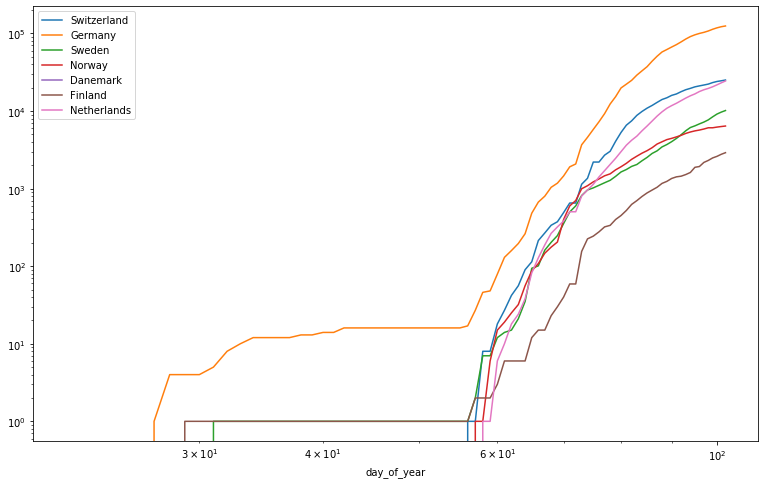

In [91]:
plot_data(nort_eu, logx=True, logy=True, figsize=(13, 8))

# Death

In [92]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [93]:
death = pd.read_csv(url)

In [94]:
death.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [95]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [96]:
uk_death = extract_data(death, "United Kingdom")

In [97]:
us_death = extract_data(death, "US", groupby=True)

In [98]:
it_death = extract_data(death, "Italy")

In [99]:
es_death = extract_data(death, "Spain")

In [100]:
de_death = extract_data(death, "Germany")

In [101]:
cn_death = extract_data(death, "China", groupby=True)

In [102]:
fr_death = extract_data(death, "France")

In [103]:
ch_death = extract_data(death, "Switzerland")

In [104]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

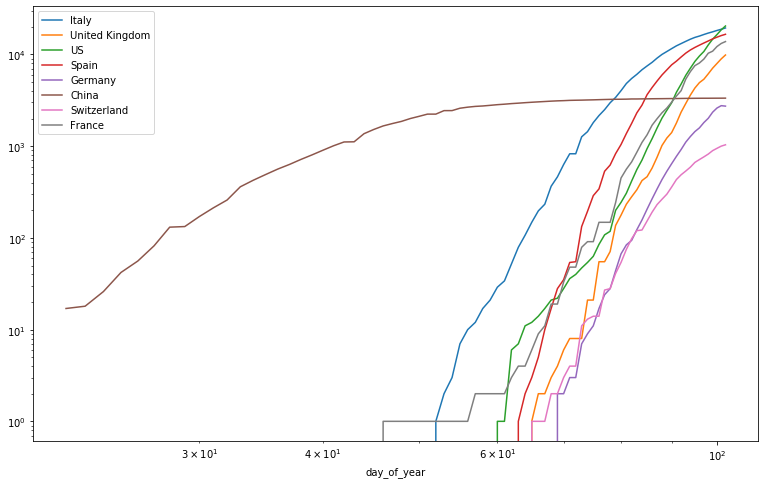

In [105]:
plot_data(comp_death, logx=True, logy=True, figsize=(13, 8))

In [106]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [107]:
world_death.index = pd.to_datetime(world_death.index)

In [108]:
world_death["day_of_year"] = world_death.index.dayofyear

In [109]:
world_death.reset_index(inplace=True)

In [110]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [111]:
world_death.set_index(["date", "day_of_year"], inplace=True)

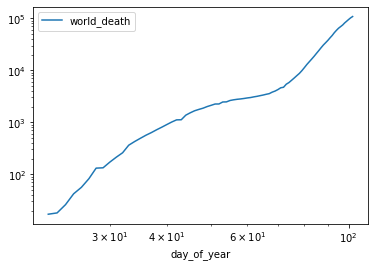

In [112]:
plot_data(world_death, logy=True, logx=True)

In [113]:
comp_world = pd.concat([world, world_death], axis=1)

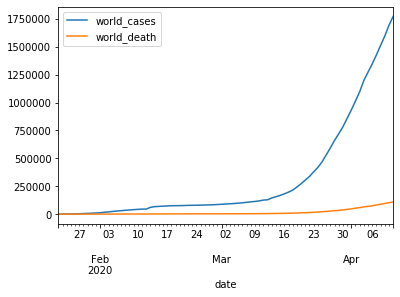

In [114]:
plot_data(comp_world)

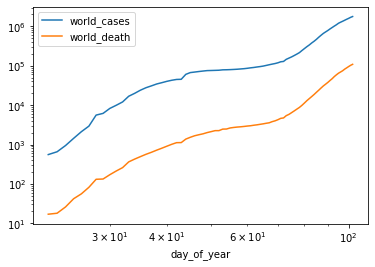

In [115]:
plot_data(comp_world, logy=True, logx=True)

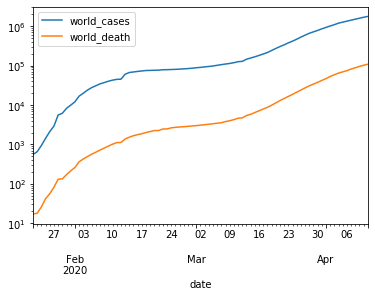

In [116]:
plot_data(comp_world, logy=True)

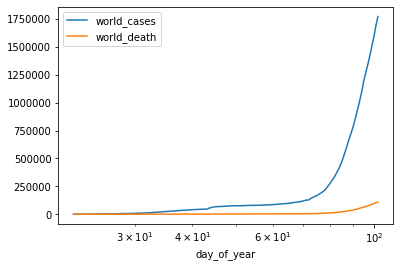

In [117]:
plot_data(comp_world, logx=True)

In [118]:
comp_world.to_excel(xl_writer, "World")

In [119]:
xl_writer.close()